In [1]:
pip install folium

In [2]:
import pandas as pd
import folium
from folium.plugins import HeatMap
from google.colab import files


In [3]:
uploaded=files.upload()

Saving AEGISDataset.csv to AEGISDataset (1).csv


In [5]:
data_manila = pd.read_csv("AEGISDataset.csv")

In [6]:
data_manila.head()

,lat,lon,flood_heig,elevation,precipitat
0,14.640394,121.055708,0,54.553295,9.0
1,14.698299,121.002132,0,21.856272,10.0
2,14.698858,121.100261,0,69.322807,16.0
3,14.571310,120.983334,0,10.987241,8.0
4,14.762232,121.075735,0,87.889847,18.0


In [7]:
import numpy as np
import pandas as pd


numeric_columns = ["lat","lon","flood_heig","elevation","precipitat"]
data_manila[numeric_columns] = data_manila[numeric_columns].apply(pd.to_numeric, errors='coerce')
data_manila_clean = data_manila.dropna()
print("NaN after cleaning:")
print(data_manila_clean.isnull().sum())

data_manila_clean["normalized_flood_heig"] = (data_manila_clean["flood_heig"]-data_manila_clean["flood_heig"].min())/(data_manila_clean["flood_heig"].max()-data_manila_clean["flood_heig"].min())
data_manila_clean["normalized_elevation"] = (data_manila_clean["elevation"]-data_manila_clean["elevation"].min())/(data_manila_clean["elevation"].max()-data_manila_clean["elevation"].min())
data_manila_clean["normalized_precipitat"] = (data_manila_clean["precipitat"]-data_manila_clean["precipitat"].min())/(data_manila_clean["precipitat"].max()-data_manila_clean["precipitat"].min())


data_manila_clean["normalized_elevation"] = 1 - data_manila_clean["normalized_elevation"]


def calculate_slope(df, radius=0.01):
    slopes = []
    print("Υπολογίζω slope για κάθε σημείο...")

    for i, row in df.iterrows():
        lat, lon, elev = row['lat'], row['lon'], row['elevation']


        distances = np.sqrt((df['lat'] - lat)**2 + (df['lon'] - lon)**2)
        neighbors = df[distances <= radius]

        if len(neighbors) > 3:
            elevation_diff = neighbors['elevation'].max() - neighbors['elevation'].min()
            distance_km = radius * 111
            slope = np.arctan(elevation_diff / (distance_km * 1000)) * 180 / np.pi
        else:
            slope = 0

        slopes.append(slope)

    return slopes


slopes = calculate_slope(data_manila_clean)
data_manila_clean['slope'] = slopes


data_manila_clean["normalized_slope"] = (data_manila_clean["slope"]-data_manila_clean["slope"].min())/(data_manila_clean["slope"].max()-data_manila_clean["slope"].min())


data_manila_clean["normalized_slope"] = 1 - data_manila_clean["normalized_slope"]

data_manila_clean["risk_score"] = (
    data_manila_clean["normalized_flood_heig"] * 0.35 +
    data_manila_clean["normalized_elevation"] * 0.25 +
    data_manila_clean["normalized_precipitat"] * 0.25 +
    data_manila_clean["normalized_slope"] * 0.15
)

print(f"\nΤελικός πίνακας: {data_manila_clean.shape}")
print(f"Risk score range: {data_manila_clean['risk_score'].min():.3f} - {data_manila_clean['risk_score'].max():.3f}")

NaN after cleaning:
lat           0
lon           0
flood_heig    0
elevation     0
precipitat    0
dtype: int64
Υπολογίζω slope για κάθε σημείο...

Τελικός πίνακας: (3510, 11)
Risk score range: 0.107 - 0.876


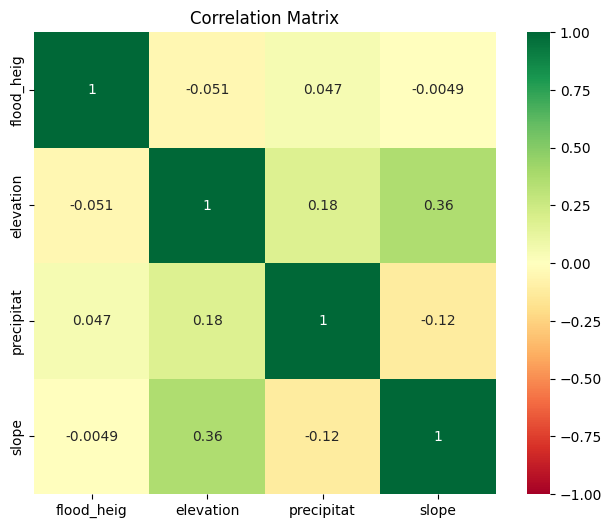

In [8]:
correlation_vars = ['flood_heig', 'elevation', 'precipitat', 'slope']
corr_matrix = data_manila_clean[correlation_vars].corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0,
           square=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Slope distribution:
count    3510.000000
mean        0.458784
std         0.444507
min         0.000000
25%         0.188105
50%         0.292484
75%         0.603674
max         2.905392
Name: slope, dtype: float64

Slopes > 5°: 0
Slopes > 10°: 0
Slopes > 20°: 0

Χαμηλότερα slopes:
          lat         lon  slope
1   14.698299  121.002132    0.0
4   14.762232  121.075735    0.0
9   14.669338  121.132898    0.0
13  14.398270  121.027496    0.0
73  14.745711  121.036145    0.0

Υψηλότερα slopes:
          lat         lon     slope
76  14.648715  121.082789  2.905392
64  14.590854  121.142181  2.809722
65  14.591124  121.142460  2.809722
66  14.591020  121.142232  2.809722
97  14.590701  121.142460  2.809722


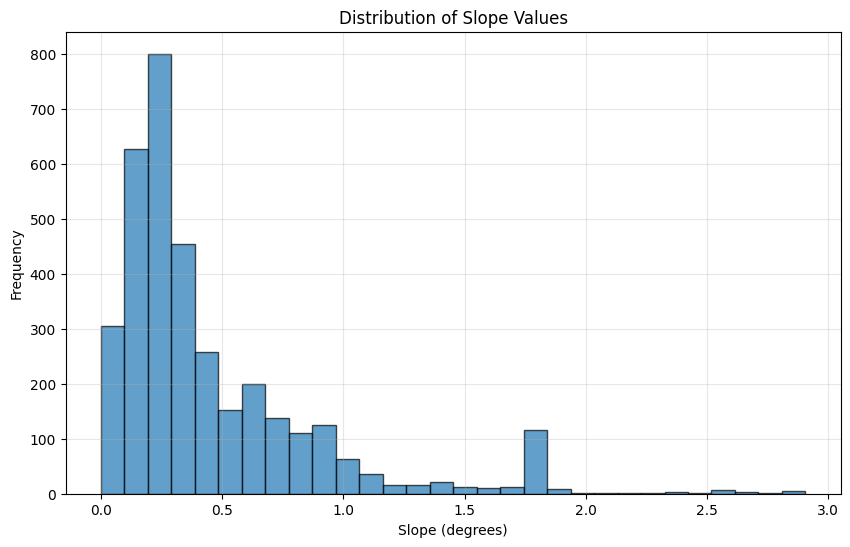

In [10]:
print("Slope distribution:")
print(data_manila_clean['slope'].describe())
print(f"\nSlopes > 5°: {(data_manila_clean['slope'] > 5).sum()}")
print(f"Slopes > 10°: {(data_manila_clean['slope'] > 10).sum()}")
print(f"Slopes > 20°: {(data_manila_clean['slope'] > 20).sum()}")


print(f"\nΧαμηλότερα slopes:")
print(data_manila_clean.nsmallest(5, 'slope')[['lat', 'lon', 'slope']])
print(f"\nΥψηλότερα slopes:")
print(data_manila_clean.nlargest(5, 'slope')[['lat', 'lon', 'slope']])


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(data_manila_clean['slope'], bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Slope (degrees)')
plt.ylabel('Frequency')
plt.title('Distribution of Slope Values')
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
print("Risk Score for Each Location")
for index, row in data_manila_clean.iterrows():
    print(f"Latitude: {row['lat']}, Longtitude: {row['lon']}, Flood Height: {row['flood_heig']}, Slope: {row['slope']:.3f}, Risk Score: {row['risk_score']:.3f}")

Risk Score for Each Location
Latitude: 14.64039374, Longtitude: 121.0557085, Flood Height: 0.0, Slope: 0.973, Risk Score: 0.308
Latitude: 14.69829935, Longtitude: 121.0021322, Flood Height: 0.0, Slope: 0.000, Risk Score: 0.460
Latitude: 14.69885841, Longtitude: 121.1002614, Flood Height: 0.0, Slope: 1.824, Risk Score: 0.308
Latitude: 14.57131006, Longtitude: 120.9833345, Flood Height: 0.0, Slope: 0.207, Risk Score: 0.455
Latitude: 14.7622323, Longtitude: 121.0757349, Flood Height: 0.0, Slope: 0.000, Risk Score: 0.375
Latitude: 14.6011784, Longtitude: 121.0885987, Flood Height: 0.0, Slope: 0.441, Risk Score: 0.469
Latitude: 14.70803089, Longtitude: 121.052674, Flood Height: 0.0, Slope: 0.760, Risk Score: 0.381
Latitude: 14.70920612, Longtitude: 121.0502922, Flood Height: 0.0, Slope: 0.309, Risk Score: 0.421
Latitude: 14.70962531, Longtitude: 121.0470059, Flood Height: 0.0, Slope: 0.309, Risk Score: 0.409
Latitude: 14.66933825, Longtitude: 121.1328981, Flood Height: 0.0, Slope: 0.000, Ri

In [12]:
def color(risk_score):
    if risk_score < 0.2:
        return 'green'
    elif 0.2 <= risk_score < 0.4:
        return 'yellow'
    elif 0.4 <= risk_score < 0.6:
        return 'orange'
    elif 0.6 <= risk_score < 0.8:
        return 'red'
    else:
        return 'dark red'

data_manila_clean['risk_color'] = data_manila_clean['risk_score'].apply(color)

manila_cords = [14.599512, 120.984222]

flood_risk_map = folium.Map(location=manila_cords, zoom_start=10)

heat_data = data_manila_clean[['lat','lon','risk_score']].values.tolist()
HeatMap(heat_data, radius=15, max_zoom=1).add_to(flood_risk_map)

print(f"\nLatitude: {data_manila_clean.iloc[-1]['lat']}, Longitude: {data_manila_clean.iloc[-1]['lon']}, Flood Height: {data_manila_clean.iloc[-1]['flood_heig']}, Risk Score: {data_manila_clean.iloc[-1]['risk_score']}, Risk Color:{data_manila_clean.iloc[-1]['risk_color']}")
flood_risk_map.save('manila_flood_risk_map.html')
flood_risk_map


Latitude: 14.65701285, Longitude: 121.0544233, Flood Height: 8, Risk Score: 0.6616374245082471, Risk Color:red
